# Reconstruct with Q-space Trajectory Imaging (QTI)

Q-space trajectory imaging (QTI) by Westin et al. (2016) is a general framework for analyzing diffusion-weighted MRI data acquired with tensor-valued diffusion encoding. This tutorial briefly summarizes the theory and provides an example of how to estimate the diffusion and covariance tensors using DIPY.

# Theory

In QTI, the tissue microstructure is represented by a diffusion tensor distribution (DTD). Here, DTD is denoted by $\mathbf{D}$ and the voxel-level diffusion tensor from DTI by $\langle\mathbf{D}\rangle$, where $\langle \ \rangle$ denotes averaging over the DTD. The covariance of $\mathbf{D}$ is given by a fourth-order covariance tensor $\mathbb{C}$ defined
as


$$\mathbb{C} = \langle \mathbf{D} \otimes \mathbf{D} \rangle - \langle
   \mathbf{D} \rangle \otimes \langle \mathbf{D} \rangle$$

where $\otimes$ denotes a tensor outer product. $\mathbb{C}$ has 21 unique
elements and enables the calculation of several microstructural parameters.

Using the cumulant expansion, the diffusion-weighted signal can be approximated
as

$$ S \approx S_0 \exp \left(- \mathbf{b} : \langle \mathbf{D} \rangle +
   \frac{1}{2}(\mathbf{b} \otimes \mathbf{b}) : \mathbb{C} \right) $$

where $S_0$ is the signal without diffusion-weighting, $\mathbf{b}$ is the
b-tensor used in the acquisition, and $:$ denotes a tensor inner product.

The model parameters $S_0$, $\langle\mathbf{D}\rangle$, and $\mathbb{C}$ can be
estimated by solving the following equation:

$$S = \beta X$$

where

$$S = \begin{pmatrix} \ln S_1 \\ \vdots \\ \ln S_n \end{pmatrix} $$

 $$  \beta = \begin{pmatrix} \ln S_0 & \langle \mathbf{D} \rangle & \mathbb{C}
   \end{pmatrix}^\text{T} $$

$$
   X =
   \begin{pmatrix}
   1 & -\mathbf{b}_1^\text{T} & \frac{1}{2} (\mathbf{b}_1 \otimes \mathbf{b}_1)
   \text{T} \\
   \vdots & \vdots & \vdots \\
   1 & -\mathbf{b}_n^\text{T} & \frac{1}{2} (\mathbf{b}_n \otimes \mathbf{b}_n)
   ^\text{T}
   \end{pmatrix} ,
$$

where $n$ is the number of acquisitions and $\langle\mathbf{D}\rangle$,
$\mathbb{C}$, $\mathbf{b}_i$, and $(\mathbf{b}_i \otimes \mathbf{b}_i)$ are
represented by column vectors using Voigt notation. Estimation of the model
parameters requires that $\text{rank}(\mathbf{X}^\text{T}\mathbf{X}) = 28$.
This can be achieved by combining acquisitions with b-tensors with different
shapes, sizes, and orientations.

For details, please see [1]_.

# Usage example

Let's start by importing the required modules and functions:

In [1]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

QTI can be fit to data using the module `dipy.reconst.qti`.

In [2]:
import dipy.reconst.qti as qti

As QTI requires data with tensor-valued encoding, let’s load an example dataset acquired with q-space trajectory encoding (QTE):

In [3]:
fdata, fbvals, fbvecs, fmask = get_fnames('qte_lte_pte')
data, affine = load_nifti(fdata)
mask, _ = load_nifti(fmask)
bvals, bvecs = read_bvals_bvecs(fbvals, fbvecs)

The dataset contains 122 volumes of which the first half were acquired with linear tensor encoding (LTE) and the second half with planar tensor encoding (PTE).

In [4]:
btens = np.array(['LTE' for i in range(61)] + ['PTE' for i in range(61)])
gtab = gradient_table(bvals, bvecs, btens=btens)

To check that bmatrices are well calculated let's inspect the ranks of the b-tensors saved in the gradient table.

In [5]:
ranks = np.array([np.linalg.matrix_rank(b) for b in gtab.btens])
for i, l in enumerate(['b = 0', 'LTE', 'PTE']):
    print('%s volumes with %s' % (np.sum(ranks == i), l))

2 volumes with b = 0
60 volumes with LTE
60 volumes with PTE


In [6]:
print(ranks)

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]


Now that we have data acquired with tensor-valued diffusion encoding and the corresponding gradient table containing the b-tensors, we can fit QTI to the data as follows:

In [7]:
qtimodel = qti.QtiModel(gtab)
qtifit = qtimodel.fit(data, mask)

QTI parameter maps can accessed as the attributes of qtifit. For instance, fractional anisotropy (FA) and microscopic fractional anisotropy (μFA) maps can be calculated as:

In [11]:
fa = qtifit.fa
ufa = qtifit.ufa

Finally, let’s reproduce Figure 9 from 1 to visualize more QTI parameter maps:

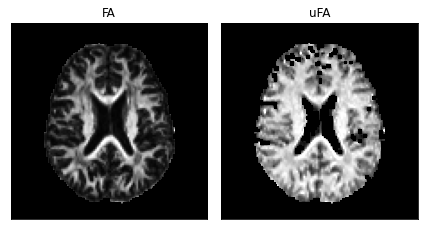

In [12]:
z = 36

fig, ax = plt.subplots(1, 2, figsize=(6, 4))

background = np.zeros(data.shape[0:2])  # Black background for figures
for i in range(2):
    ax[i].imshow(background, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])


ax[0].imshow(np.rot90(fa[:, :, z]), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('FA')

ax[1].imshow(np.rot90(ufa[:, :, z]), cmap='gray', vmin=0, vmax=1)
ax[1].set_title('uFA')


fig.tight_layout()
plt.show()

Finally, let’s reproduce Figure 9 from 1 to visualize more QTI parameter maps:

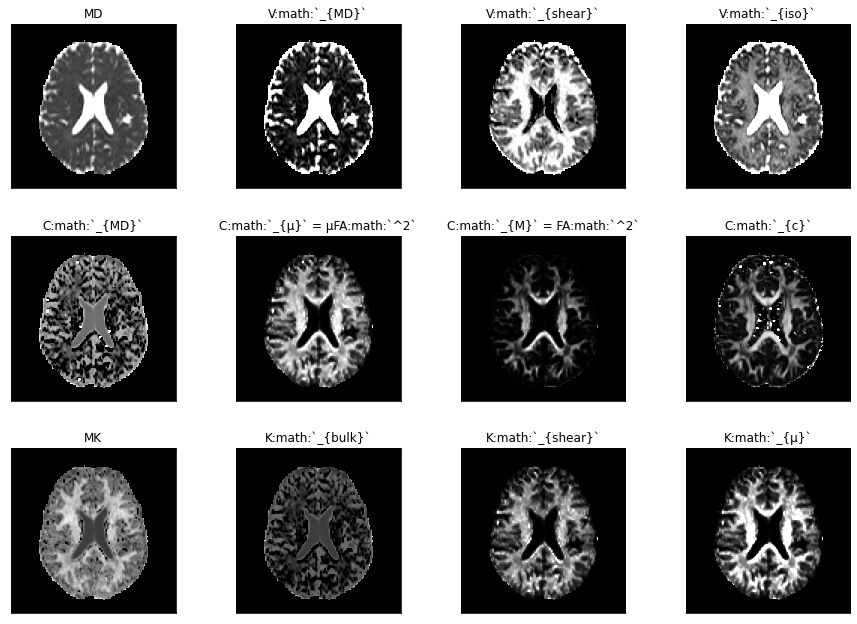

In [13]:
z = 36

fig, ax = plt.subplots(3, 4, figsize=(12, 9))

background = np.zeros(data.shape[0:2])  # Black background for figures
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(background, cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

ax[0, 0].imshow(np.rot90(qtifit.md[:, :, z]), cmap='gray', vmin=0, vmax=3e-3)
ax[0, 0].set_title('MD')
ax[0, 1].imshow(np.rot90(qtifit.v_md[:, :, z]),
                cmap='gray', vmin=0, vmax=.5e-6)
ax[0, 1].set_title('V:math:`_{MD}`')
ax[0, 2].imshow(np.rot90(qtifit.v_shear[:, :, z]), cmap='gray', vmin=0,
                vmax=.5e-6)
ax[0, 2].set_title('V:math:`_{shear}`')
ax[0, 3].imshow(np.rot90(qtifit.v_iso[:, :, z]),
                cmap='gray', vmin=0, vmax=1e-6)
ax[0, 3].set_title('V:math:`_{iso}`')

ax[1, 0].imshow(np.rot90(qtifit.c_md[:, :, z]), cmap='gray', vmin=0, vmax=.25)
ax[1, 0].set_title('C:math:`_{MD}`')
ax[1, 1].imshow(np.rot90(qtifit.c_mu[:, :, z]), cmap='gray', vmin=0, vmax=1)
ax[1, 1].set_title('C:math:`_{μ}` = μFA:math:`^2`')
ax[1, 2].imshow(np.rot90(qtifit.c_m[:, :, z]), cmap='gray', vmin=0, vmax=1)
ax[1, 2].set_title('C:math:`_{M}` = FA:math:`^2`')
ax[1, 3].imshow(np.rot90(qtifit.c_c[:, :, z]), cmap='gray', vmin=0, vmax=1)
ax[1, 3].set_title('C:math:`_{c}`')

ax[2, 0].imshow(np.rot90(qtifit.mk[:, :, z]), cmap='gray', vmin=0, vmax=1.5)
ax[2, 0].set_title('MK')
ax[2, 1].imshow(np.rot90(qtifit.k_bulk[:, :, z]),
                cmap='gray', vmin=0, vmax=1.5)
ax[2, 1].set_title('K:math:`_{bulk}`')
ax[2, 2].imshow(np.rot90(qtifit.k_shear[:, :, z]), cmap='gray', vmin=0,
                vmax=1.5)
ax[2, 2].set_title('K:math:`_{shear}`')
ax[2, 3].imshow(np.rot90(qtifit.k_mu[:, :, z]), cmap='gray', vmin=0, vmax=1.5)
ax[2, 3].set_title('K:math:`_{μ}`')

fig.tight_layout()
plt.show()

For more information about QTI, please read the article by Westin et al. (2016)

Westin, Carl-Fredrik, et al. “Q-space trajectory imaging for multidimensional diffusion MRI of the human brain.” Neuroimage 135 (2016): 345-362. https://doi.org/10.1016/j.neuroimage.2016.02.039.